In [1]:
%load_ext autoreload

%autoreload 2

import pickle
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from os import chdir

from tqdm import tqdm

import Functions.Ensemble_Assimilation as EA
import Functions.Import_Data as ID
import Functions.Feflow_Utils as FU
import Functions.Localization_Methods as LM

## Defining folder path

In [3]:
chdir("D:\Dropbox\FEFLOW_MDA_MPMW_500_20_amplifie")
path_data = "D:\Dropbox\FEFLOW_MDA_MPMW_500_20_amplifie\Data\\"

## Loading elements coordinates in FEFLOW model

In [4]:
elementsCoordinates = pd.read_pickle(path_data+"FEFLOW_Model\\feflow_element")
elementsCoordinates.head()

,index,X,Y,Z,ElementID,Slice,K_zone
0,0,280756.522283,5.009264e+06,34.117244,1.0,1.0,20.0
1,1,285026.150151,5.005082e+06,41.451557,2.0,1.0,40.0
2,2,280565.971528,5.009600e+06,37.019960,3.0,1.0,20.0
3,3,292409.545083,5.021921e+06,40.972872,4.0,1.0,40.0
4,4,280731.027094,5.009417e+06,35.698680,5.0,1.0,20.0


## Keeping only the updated element in the complete FEFLOW model

In [5]:
elementsCoordinatesLocal = np.load(path_data+"FEFLOW_Model\\updated_element.npy")
elementsCoordinatesLocal = elementsCoordinates[elementsCoordinates.ElementID.isin(elementsCoordinatesLocal)]

## Defining global variable acting on the method

In [6]:
# assim_number is the current assimilation in the multiple data assimilation process 
assim_number = 0


# update_amplifier is the amplifier factor to increase the scale of the update. 1 to don't modify it
# Larger than 1 to amplify it 
update_amplifier = 4

# Some parameters are defined globaly in FEFLOW model, these one are not localized during the assimilation process
number_of_global_parameter = 45

## Loading parameters sent to FEFLOW

In [7]:
path = path_data+"Assim_"+str(assim_number)+"/Individual_Update/"

files = [f for f in listdir(path) if isfile(join(path, f))]

imported_ensemble_parameter_feflow = np.zeros((len(files),len(elementsCoordinates)+number_of_global_parameter))

i = 0
for file in files:
    imported_ensemble_parameter_feflow[i] = np.load(path_data+"Assim_"+str(assim_number)+"/Individual_Update/"+file)
    i += 1

### Splitting global and local variable for localization purpose in assimilation process

In [8]:
globalParameters = imported_ensemble_parameter_feflow.T[-number_of_global_parameter:]

localParameters = imported_ensemble_parameter_feflow.T[:-number_of_global_parameter]

del imported_ensemble_parameter_feflow

## Loading observation coordinates in the model 

In [9]:
observationPoints = pd.read_csv(path_data+"FEFLOW_Model\\well_location.inp")

In [10]:
observationPoints.head()

,LocName,X,Y,Z,Z_Type,Variable,Date,HHmasl,Weight,Group,Date2021
0,zzPO-20-6D,286929.6802,5016097.280,9.0,slice,Head,1900-01-01,36.71,0.0,TestUTES,NaN
1,zzPO-20-7D,285750.6738,5015807.612,9.0,slice,Head,1900-01-01,36.09,0.0,TestUTES,NaN
2,zzPO-20-8D,286296.7871,5015765.074,9.0,slice,Head,1900-01-01,34.69,0.0,TestUTES,NaN
3,zzPO-20-9D,286717.6479,5015694.551,9.0,slice,Head,1900-01-01,36.13,0.0,TestUTES,NaN
4,zzzF-124-A,286464.8862,5016086.372,9.0,slice,Head,1900-01-01,33.91,0.0,TestUTES,NaN


## Creation of the localization weight around each observation point

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  9.75it/s]


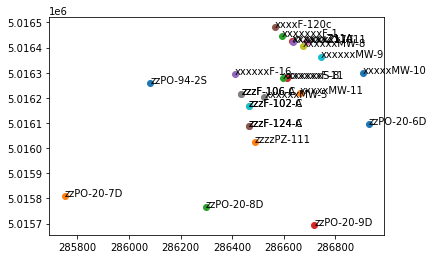

In [11]:
for i in tqdm(range(len(observationPoints))):
    
    x_obs = observationPoints.iloc[i].X
    y_obs = observationPoints.iloc[i].Y
    z_obs = observationPoints.iloc[i].Z

    max_range = 500
    med_range = 500
    min_range = 20
    azimuth = 0
    dip = 0
    vario_type = "gaussian"
    sill = 1
    nugget = 0
    
    
    
    index, weights = LM.extract_feflow_from_ellipsoid(elementsCoordinatesLocal,
                                  x_obs,
                                  y_obs,
                                  z_obs,
                                  max_range,
                                  med_range,
                                  min_range,
                                  azimuth,
                                  dip,
                                  sill,
                                  nugget,
                                  vario_type)

    
    index = index.astype('uint32')
    tempFile = np.array([index,weights])

    tempFile.T

    np.save(path_data+"Weights/weight_"+observationPoints.iloc[i].LocName,tempFile)
    
    del index
    del weights
    
        
    plt.scatter(x_obs,y_obs)
    plt.text(x_obs,y_obs,s=observationPoints.iloc[i].LocName)
    
    
    if False :
        plt.figure(figsize=(20,10))
        plt.scatter(elementsCoordinates.iloc[tempFile[0][0:100000]].X.values,
                    elementsCoordinates.iloc[tempFile[0][0:100000]].Y.values,
                   c=tempFile[1][0:100000])
        plt.title(observationPoints.iloc[i].LocName)
        plt.colorbar()
        plt.show()
plt.show()
    

### Creation of a global weighting matrix to compute the information weighting coming from each assimilation

In [12]:
numOfAssimilatedWell = len(observationPoints)

obsPointNames = [f for f in listdir(path_data + "Weights/") if isfile(join(path_data + "Weights/", f))]

dampingWeight = []

for i in range(numOfAssimilatedWell):
    dampingWeight.append(np.load(path_data + "Weights/"+obsPointNames[i]).T)
    
    
globalDampingWeights = np.zeros((len(dampingWeight),len(elementsCoordinates)+45))
#globalDampingWeights = np.zeros((len(dampingWeight),len(elementsCoordinates)))

for i in range(len(dampingWeight)):
    globalDampingWeights[i][(dampingWeight[i].T[0]).astype(int)] = dampingWeight[i].T[1]

globalDampingWeights = globalDampingWeights.T
#Last number_of_global_parameter are global parameters, not weight to observation as they are global
globalDampingWeights[-number_of_global_parameter:] = 1


globalDampingWeights = np.divide(globalDampingWeights.T, globalDampingWeights.sum(axis=1), out=np.zeros_like(globalDampingWeights.T), where=globalDampingWeights.sum(axis=1)!=0)

### Verification of weighting around a subset of the last observation to control the quality

100000 elements are displayed, be carefull with all z projected in a single 2d plan

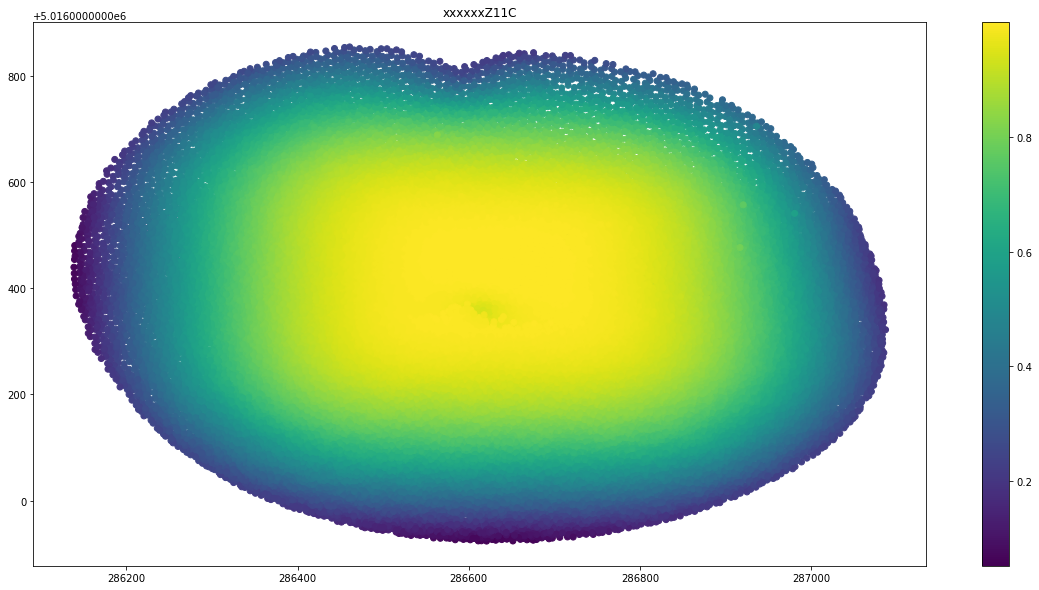

In [13]:
plt.figure(figsize=(20,10))
plt.scatter(elementsCoordinates.iloc[tempFile[0][0:100000]].X.values,
            elementsCoordinates.iloc[tempFile[0][0:100000]].Y.values,
           c=tempFile[1][0:100000])
plt.title(observationPoints.iloc[i].LocName)
plt.colorbar()
plt.show()

## Loading results and observation

In [15]:
ID.resample_time(path_data+'Assim_'+str(assim_number)+'/Head/',path_data+'Assim_'+str(assim_number)+'/Head_resampled/')
ID.load_results(assim_number, path_data[:-5])

measured_head = ID.Measure(path_data+'/Assim_'+str(assim_number)+'/measured_head.txt')
observed_head = ID.Observation(path_data+'/Assim_'+str(assim_number)+'/observed_head.txt')

### Plotting some individual simulated hydraulic head for a given well

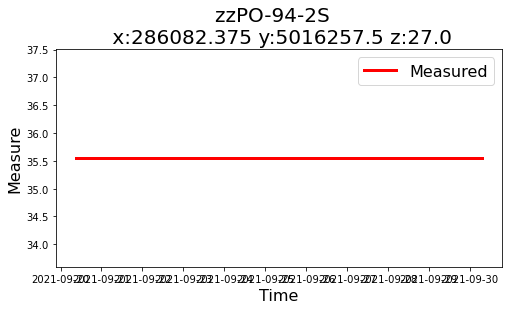

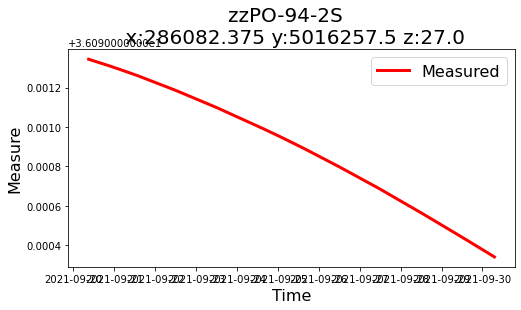

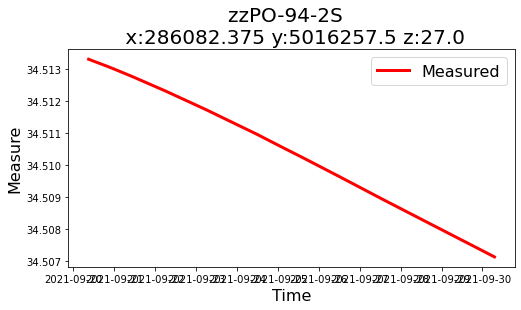

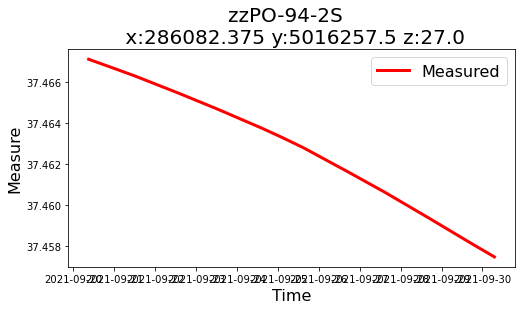

In [16]:
wellNumber = 10

# Showing the real data
measured_head.wells[wellNumber].plot()

# Showing 3 realizations of the simulated data
for i in range(3) :
    observed_head.wells[wellNumber][i].plot()

## Assimilating data with 45 global parameters, and a varying number of local parameters

In [17]:
ensembleMatrix = np.array(np.log(localParameters),dtype=np.float32)

del localParameters


# Log transform of permeability global parameters

temp_array = np.array(globalParameters)
# If log transform is necessary
temp_array[0:number_of_global_parameter] = np.log(temp_array[0:number_of_global_parameter])

ensembleMatrix = np.vstack((ensembleMatrix,temp_array))

del temp_array
del globalParameters


globalUpdate = np.copy(ensembleMatrix)


for wellObservedNumber in tqdm(range(numOfAssimilatedWell)):
        
    # Keeping only elements with weights higher than 0 in dictionnary containing all the weights
    tempWeights = globalDampingWeights[wellObservedNumber][np.where(globalDampingWeights[wellObservedNumber]>0)]


    temp_ensemble = np.zeros((len(tempWeights),ensembleMatrix.shape[1]))

    temp_ensemble = np.vstack((ensembleMatrix[(dampingWeight[wellObservedNumber].T[0]).astype(int)],ensembleMatrix[-number_of_global_parameter:]))


    temp_ensemble = np.matrix(temp_ensemble)


    assim_measurement = measured_head.wells[wellObservedNumber].get_well_data()[1]

    assim_observed = np.zeros(( ensembleMatrix.shape[1], len(observed_head.wells[wellObservedNumber][0].get_well_data()[1])),dtype=np.float32)


    for j in range(ensembleMatrix.shape[1]):
        assim_observed[j] = observed_head.wells[wellObservedNumber][j].get_well_data()[1]


    # Assimilation process

    percent_error = 0.01 # Stochastic std noise on measures

    assimilation = EA.Assimilation(temp_ensemble, 
                   assim_measurement,
                   assim_observed.T,                 
                   percent_error,
                   inflation_factor = 1.01,                                
                   show_parameters=False)

    assimilation.stochastic()
    
    individualWeightedUpdate = np.multiply(update_amplifier * assimilation.dE.T,tempWeights) 


    globalUpdate[(dampingWeight[wellObservedNumber].T[0]).astype(int)] += individualWeightedUpdate.T[:-number_of_global_parameter]
    globalUpdate[-number_of_global_parameter:] += individualWeightedUpdate.T[-number_of_global_parameter:] 


    # Cleaning memory at each iteration to optimize RAM impact
    del individualWeightedUpdate
    del assim_measurement
    del assim_observed
    del temp_ensemble
    del tempWeights
    del assimilation

del globalDampingWeights
del dampingWeight
del ensembleMatrix

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:18<00:00,  1.35it/s]


## Log values are trimmed after assimilation to insure FEFLOW convergence  

In [18]:
for i in range(globalUpdate.shape[0]):
    globalUpdate[i][np.where(globalUpdate[i]<-15)] = -15
    globalUpdate[i][np.where(globalUpdate[i]>9)] = 9

### Reconverting log permeability to permeability, Additionnal check to insure no negative value in Kz multiplier or recharge

In [19]:
globalUpdate = np.exp(globalUpdate)

In [20]:
globalUpdate1 = globalUpdate.T

In [21]:
i = 0
for file in files:
    np.save(path_data+"Assim_"+str(assim_number+1)+"/Individual_Update/assim_"+str(assim_number+1)+"_model_"+file[14:-4],globalUpdate1[i])
    i +=1

In [22]:
del globalUpdate